## Section 07: Combining the Blocks

Look again at the diagram of the transformer in Lesson 05. You will see that the encoder is the self-attention submodel connected to the feed-forward submodel. The decoder, on the other hand, is a self-attention submodel, a cross-attention submodel, and a feed-forward submodel connected in tandem.

First, we re-load the functions defined in Section 6. I saved them in the file *transformerBuildingBlocks.py*. Then, we put together the input, self-attention, and feedforward layers using Keras sequential API.

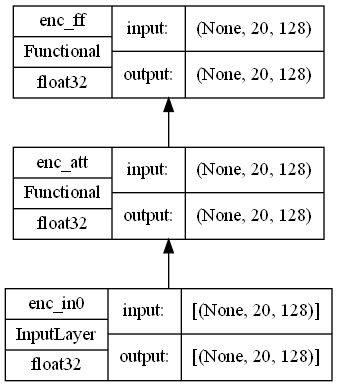

In [17]:
import tensorflow as tf
#from transformerBuildingBlocks import self_attention, feed_forward
from transformer_building_blocks import self_attention, feed_forward

def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """One encoder unit. The input and output are in the same shape so we can
    daisy chain multiple encoder units into one larger encoder"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, mask=False, prefix=prefix, key_dim=key_dim, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model
  
seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8
 
model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "section07_figure01_encoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

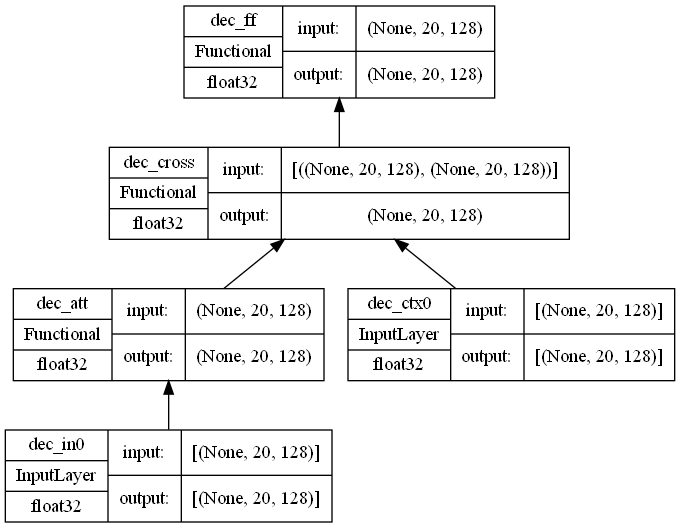

In [18]:
import tensorflow as tf
from transformerBuildingBlocks import self_attention, feed_forward, cross_attention

def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience"""
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                              prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)

tf.keras.utils.plot_model(model, "section07_figure02_decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

Finally, we add the *encoder* and *decoder* to the *transformer_building_blocks.py* file to load them later.